In [27]:
import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import os
import sys
import numpy as np
from qiskit.quantum_info import pauli_basis, PTM

home_folder = os.getcwd()
while not home_folder.endswith("AutomatedPERTools"):
    home_folder = os.path.dirname(home_folder)
sys.path.append(os.path.join(home_folder, "pauli_lindblad_per"))
import pickle

In [28]:
def decipher_name(namebase):
    i = 0
    dic = dict()
    split_namebase = namebase.split("_")
    #parser.add_argument('--plusone', '-p', help='Takes Neighboring qubits into account', default=False, action='store_true')
    #i, dic["tomography_connections"] = i+1, (split_namebase[i] == "True")
    #parser.add_argument('--sum', '-s', help='Same as -p and turns sumation on over neighboring qubits', default=False, action='store_true')
    i, dic["sum_over_lambda"] = i+1, (split_namebase[i] == "True")
    if dic["sum_over_lambda"]:
        dic["tomography_connections"] = True
    #parser.add_argument('--pntsamples', type=int, help='How many samples in PNT? Default: 16', default=16)
    i, dic["pntsamples"] = i+1, int(split_namebase[i])
    #parser.add_argument('--pntsinglesamples', type=int, help='How many single samples in PNT? Default: 100', default=100)
    i, dic["pntsinglesamples"] = i+1, int(split_namebase[i])
    #parser.add_argument('--persamples', type=int, help='How many samples in PER? Default: 100', default=100)
    i, dic["persamples"] = i+1, int(split_namebase[i])
    #parser.add_argument('--shots', type=int, help='How many shots? Default: 1000', default=1000)
    i, dic["shots"] = i+1, int(split_namebase[i])
    #parser.add_argument('--backend', type=str, help='Which backend to use? Default: FakeVigoV2', default="FakeVigoV2")
    import qiskit.providers.fake_provider as fake_provider
    backend = fake_provider.FakeVigoV2()
    if split_namebase[i] != "FakeVigoV2":
        method = getattr(fake_provider, split_namebase[i])
        backend = method()
    dic["backend"] = backend
    dic["backend_literal"] = split_namebase[i]
    i+=1

    #parser.add_argument('--cross', '-c', help='Simulates Cross Talk Noise', default=False, action='store_true')
    i, dic["do_cross_talk_noise"] = i+1, (split_namebase[i] == "True")
    #parser.add_argument('--allqubits', '-a', help='runs over all qubits in the tomography', default=False, action='store_true')
    #i, dic["allqubits"] = i+1, (split_namebase[i] == "True")
    #parser.add_argument('--onlyTomography', help='Only does the tomography and then ends the program', default=False, action='store_true')
    i, dic["onlyTomography"] = i+1, (split_namebase[i] == "True")

    #parser.add_argument('--setqubits', type=int, nargs='+', help='Which qubits to use?: Default: 0123 and transpile')
    import ast
    i, dic["qubits"]= i+1, ast.literal_eval(split_namebase[i])
    if dic["qubits"] !=  [0,1,2,3]:
        dic["num_qubits"] = backend.num_qubits    
    else:
        dic["num_qubits"] = len(dic["qubits"])
    #if split_namebase[7] == '[0,1,2,3]' and split_namebase[8] == 'and' and split_namebase[9] == 'transpile':
    return dic

In [29]:
# Determine Folders
main_folder_path = "tutorial_notebooks/testrun/server_run_collection".split('/')
main_folder = ""
for segment in main_folder_path:
    main_folder = os.path.join(main_folder, segment)
folders = [f for f in os.listdir(os.path.join(home_folder, main_folder)) if os.path.isdir(os.path.join(os.path.join(home_folder, main_folder), f))]
filtered_folders = [f for f in folders if not "outputs" in f 
                    and not decipher_name(f)["do_cross_talk_noise"] 
                    and decipher_name(f)["pntsamples"]== 16
                    and "CNOT" in f and "FakeVigoV2" in f and "CNOT_LAYER1" in f
                    and decipher_name(f)["qubits"]== {1,2}]
for folder in filtered_folders:
    print(folder)

False_16_100_100_1024_FakeVigoV2_False_True_{1, 2}_[2, 4, 8, 16]_CNOT_LAYER1


In [30]:
# Load Data
coeffs_datas = []
infidelities_datas = []
for folder in filtered_folders:
    print(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "coeffs.pickle"))
    with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "coeffs.pickle"), "rb") as f:
        coeffs = pickle.load(f)
    coeffs_datas.append(coeffs)
    with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "infidelities.pickle"), "rb") as f:
        infidelities = pickle.load(f)
        """ 
        print(infidelities)
        inf2 = []
    for inf in infidelities:
        tempdic = {}
        for temp2 in inf:
            for i in temp2:
                print(i)
                tempdic[i] = temp2[i]
        inf2.append(tempdic)
    print(coeffs)
    print(inf2)
    infidelities = inf2
    with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "infidelities.pickle"), "wb") as f:
        pickle.dump(infidelities, f) """
    infidelities_datas.append(infidelities)

e:\OneDrive\Dokumente\Uni_kram\Masterarbeit\AutomatedPERTools\tutorial_notebooks\testrun\server_run_collection\False_16_100_100_1024_FakeVigoV2_False_True_{1, 2}_[2, 4, 8, 16]_CNOT_LAYER1\coeffs.pickle


In [31]:
def make_initial_Circuit2(backend):
    from qiskit import transpile, QuantumCircuit
    circuit = QuantumCircuit(5)
    circuit.cx(1,2)
    #circuit.cx(1,2)
    return [circuit]
    return [transpile(circuit, backend)]

In [32]:
with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),filtered_folders[0]), "noise_model.pickle"), "rb") as f:
    (noise_model, twoqubit_error_template, singlequbit_error_template) = pickle.load(f)
#from TrotterExample import get_noise_model, make_initial_Circuit, make_initial_Circuit2
#(noise_model, twoqubit_error_template, singlequbit_error_template) = get_noise_model()
dic = decipher_name(filtered_folders[0])
backend = dic["backend"]
circuit = make_initial_Circuit2(backend)[0]
print(circuit)

          
q_0: ─────
          
q_1: ──■──
     ┌─┴─┐
q_2: ┤ X ├
     └───┘
q_3: ─────
          
q_4: ─────
          


In [33]:
def get_index(qc, inst, i=None):
    if i:
        qubit = inst.qubits[i]
        index = -1
        for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
            if qubit in register:
                index = register.index(qubit)
                break
        return index
    else:
        qubits = inst.qubits
        indexes = []
        for qubit in qubits:
            index = -1
            for register in qc.qregs:  # Assuming you're using `QuantumCircuit`
                if qubit in register:
                    index = register.index(qubit)
                    break
            indexes.append(index)
        return indexes

In [34]:
sys.path.append(os.path.join(os.path.join(home_folder, "tutorial_notebooks"),"testrun"))
from TrotterExample import circuit_to_layers
from primitives.circuit import QiskitCircuit

layers = circuit_to_layers(QiskitCircuit(circuit))

In [35]:
def get_error_for_circuit(circuit, twoqubit_error_template, singlequbit_error_template, backend):
    from qiskit.quantum_info import Pauli
    def mul_Pauli(pauli1, pauli2):
        result = pauli1.compose(pauli2)
        nophase = Pauli((result.z, result.x))
        return nophase

    num_qubits = backend.num_qubits
    identity_string = 'I'*num_qubits
    error_state = {Pauli(identity_string): 1}
    for inst in circuit:
        temp_error_state = {}
        indexes = get_index(circuit, inst)
        if inst.operation.name == "cx":
            for og_op in error_state:
                op = og_op
                if og_op[indexes[0]] == 'X' or og_op[indexes[0]] == 'Y':
                    temp_op = Pauli("".join(reversed(identity_string[:indexes[1]] + 'X' + identity_string[indexes[1]+1:])))
                    op = mul_Pauli(temp_op, op)
                if og_op[indexes[1]] == 'Z' or og_op[indexes[1]] == 'Y':
                    temp_op = Pauli("".join(reversed(identity_string[:indexes[0]] + 'Z' + identity_string[indexes[0]+1:])))
                    op = mul_Pauli(temp_op, op)
                temp_error_state[op] = error_state[og_op]
            error_state = temp_error_state
            temp_error_state = {}
        if len(indexes) == 1:
            index = indexes[0]
            for (op, p) in singlequbit_error_template:
                op = Pauli("".join(reversed(identity_string[:index] + str(op)+ identity_string[index+1:])))
                for og_op in error_state:
                    og_p = error_state[og_op]
                    new_op = mul_Pauli(op, og_op)
                    temp_error_state[new_op] = temp_error_state.get(new_op, 0) + p*og_p
        elif len(indexes) == 2:
            for (op, p) in twoqubit_error_template:
                temp_string = (identity_string[:indexes[0]] + "".join(reversed(str(op)))[0]+ identity_string[indexes[0]+1:])
                op = Pauli("".join(reversed(temp_string[:indexes[1]] + "".join(reversed(str(op)))[1]+ temp_string[indexes[1]+1:])))
                for og_op in error_state:
                    og_p = error_state[og_op]
                    new_op = mul_Pauli(op, og_op)
                    temp_error_state[new_op] = temp_error_state.get(new_op, 0) + p*og_p
        else:
            if inst.operation.name == 'barrier':
                continue
            raise Exception("Too many qubits")
        error_state = temp_error_state
    return [(op, error_state[op]) for op in error_state]

In [36]:
def model_terms(layer, *list):
    return layer._model_terms(list)

In [37]:
def splice_string(string, indexes):
    for index in sorted(indexes):
        index -= sorted(indexes).index(index)
        string = string[:index]+string[index+1:]
    return string

In [38]:
choosen_qubits = [0,1,2,3,4]
layer_number = 0
groups = []
used_qubits = len(choosen_qubits)
for qubit in choosen_qubits:
    groups += [pauli for pauli in pauli_basis(used_qubits) if str(pauli)[::-1][qubit] != 'I' and (splice_string(str(pauli)[::-1], [qubit]) == 'I'*(used_qubits-1))]
for qubit1 in choosen_qubits:
    for qubit2 in choosen_qubits:
        if qubit1 <= qubit2:
            continue
        elif qubit1 == qubit2 +1:
            print(qubit1, qubit2)
            groups += [pauli for pauli in pauli_basis(used_qubits) if str(pauli)[::-1][choosen_qubits[qubit1]] != 'I' and str(pauli)[::-1][choosen_qubits[qubit2]] != 'I' and (splice_string(str(pauli)[::-1], [choosen_qubits[qubit1], choosen_qubits[qubit2]]) == 'I'*(used_qubits-2))]
print(groups)

1 0
2 1
3 2
4 3
[Pauli('IIIIX'), Pauli('IIIIY'), Pauli('IIIIZ'), Pauli('IIIXI'), Pauli('IIIYI'), Pauli('IIIZI'), Pauli('IIXII'), Pauli('IIYII'), Pauli('IIZII'), Pauli('IXIII'), Pauli('IYIII'), Pauli('IZIII'), Pauli('XIIII'), Pauli('YIIII'), Pauli('ZIIII'), Pauli('IIIXX'), Pauli('IIIXY'), Pauli('IIIXZ'), Pauli('IIIYX'), Pauli('IIIYY'), Pauli('IIIYZ'), Pauli('IIIZX'), Pauli('IIIZY'), Pauli('IIIZZ'), Pauli('IIXXI'), Pauli('IIXYI'), Pauli('IIXZI'), Pauli('IIYXI'), Pauli('IIYYI'), Pauli('IIYZI'), Pauli('IIZXI'), Pauli('IIZYI'), Pauli('IIZZI'), Pauli('IXXII'), Pauli('IXYII'), Pauli('IXZII'), Pauli('IYXII'), Pauli('IYYII'), Pauli('IYZII'), Pauli('IZXII'), Pauli('IZYII'), Pauli('IZZII'), Pauli('XXIII'), Pauli('XYIII'), Pauli('XZIII'), Pauli('YXIII'), Pauli('YYIII'), Pauli('YZIII'), Pauli('ZXIII'), Pauli('ZYIII'), Pauli('ZZIII')]


In [39]:
from qiskit.quantum_info import Pauli
singlequbit_error_template = [(Pauli('I'), 1)]
singlequbit_error_template

[(Pauli('I'), 1)]

In [40]:
def swap_first_two_chars(s):
    # If the string has less than 2 characters, return the string as it is
    if len(s) < 2:
        return s
    # Swap the first two characters
    return s[1] + s[0] + s[2:]

In [41]:
true_error_template = {pauli: error for pauli, error in get_error_for_circuit(circuit, twoqubit_error_template, singlequbit_error_template, backend)}
#true_error_template = {swap_first_two_chars("".join(reversed(splice_string("".join(reversed(str(key))), [i for i in range(len(str(key))) if not i in [1,3,5,6]])))):true_error_template[key] for key in true_error_template}
true_error_template = {str(key):true_error_template[key] for key in true_error_template}
print(true_error_template)

{'IIIXI': 0.25, 'IIIII': 0.75}


In [42]:
#import qiskit.providers.fake_provider as fake_provider
#backend = fake_provider.FakeVigoV2()
#circuit = make_initial_Circuit([0,1,2,3], 4, backend, 2)[0]
#print(circuit)

In [43]:
from qiskit.providers.aer.noise import pauli_error
#import qiskit.providers.fake_provider as fake_provider
#backend = fake_provider.FakeVigoV2()
#layers = circuit_to_layers(QiskitCircuit(make_initial_Circuit([0,1,2,3], 4, backend, 2)[0]))
#true_error_template = {pauli: error for pauli, error in get_error_for_circuit(layers[layer_number].qc, twoqubit_error_template, singlequbit_error_template, backend)}
#true_error_template = {"".join(reversed(splice_string("".join(reversed(str(key))), [i for i in range(len(str(key))) if not i in [1,2,3,4]]))):true_error_template[key] for key in true_error_template}
print(true_error_template)

{'IIIXI': 0.25, 'IIIII': 0.75}


In [44]:
#true_error = pauli_error(get_error_for_circuit(layers[layer_number].qc, twoqubit_error_template, singlequbit_error_template, backend))

In [45]:
# Make error strings
twoqubit_error_string = ""
for temp in twoqubit_error_template:
    twoqubit_error_string = twoqubit_error_string + str(temp[0])+":" +"%.7s"%temp[1]+"   "

singlequbit_error_string = ""
for temp in singlequbit_error_template:
    singlequbit_error_string = singlequbit_error_string +" "+ str(temp[0])+":" +"%.7s"%temp[1]+"   "

In [46]:
# Make / load transfer matrix
transfer_matrix = None
for folder in filtered_folders:
    if os.path.exists(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrixes.pickle")):
        with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrixes.pickle"), "rb") as f:
            transfer_matrixes = pickle.load(f)
            transfer_matrix = transfer_matrixes[layer_number]

if transfer_matrix is None:
    for folder in filtered_folders:
        if os.path.exists(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrix.pickle")):
            with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrix.pickle"), "rb") as f:
                (transfer_matrix, saved_layer_number) = pickle.load(f)
                if saved_layer_number != layer_number:
                    transfer_matrix = None
                    
if transfer_matrix is None:
    pass
    #transfer_matrix = PTM(true_error.to_quantumchannel()).data #Find out more about this
    
for folder in filtered_folders:
    pass
    #with open(os.path.join(os.path.join(os.path.join(home_folder, main_folder),folder), "transfer_matrix.pickle"), "wb") as f:
    #    pickle.dump((transfer_matrix, layer_number), f)

In [47]:
coe = True
infidelities_list = []
coeffs_list = []
labels = []
#stack = {pauli: (1-transfer_matrix[i][i]).real for i,pauli in enumerate(pauli_basis(backend.num_qubits))}
#stack = [stack[pauli] for pauli in groups]
#infidelities_list.append(stack)
coeffs_list.append([true_error_template.get(str(pauli), 0) for pauli in groups])
labels.append("Real Error")

In [48]:
def swap_last_two_chars(s):
    # If the string has less than 2 characters, return the string as it is
    if len(s) < 2:
        return s
    # Swap the last two characters
    return s[:-2] + s[-1] + s[-2]

In [49]:
failed_folders = 0
for array_of_coeffs, array_of_infidelities, folder in zip(coeffs_datas, infidelities_datas, filtered_folders):
    cipher = decipher_name(folder)
    coeffs = array_of_coeffs[layer_number]
    infidelities = array_of_infidelities[layer_number]
    #if cipher["backend_literal"] == "FakeCasablancaV2":
    #    coeffs = array_of_coeffs[1]
    #    infidelities = array_of_infidelities[1]
    #else:
    #    coeffs = array_of_coeffs[layer_number]
    #    infidelities = array_of_infidelities[layer_number]
    #if cipher["backend_literal"] == "FakeMelbourneV2" or cipher["backend_literal"] == "FakeCasablancaV2":
    #    coeffs = {swap_last_two_chars("".join(reversed(splice_string("".join(reversed(str(key))), [i for i in range(len(str(key))) if not i in decipher_name(folder)["qubits"]])))):coeffs[key] for key in coeffs}
    #    infidelities = {swap_last_two_chars("".join(reversed(splice_string("".join(reversed(str(key))), [i for i in range(len(str(key))) if not i in decipher_name(folder)["qubits"]])))):infidelities[key] for key in infidelities}
    #else:
    #    coeffs = {"".join(reversed(splice_string("".join(reversed(str(key))), [i for i in range(len(str(key))) if not i in decipher_name(folder)["qubits"]]))):coeffs[key] for key in coeffs}
    #    infidelities = {"".join(reversed(splice_string("".join(reversed(str(key))), [i for i in range(len(str(key))) if not i in decipher_name(folder)["qubits"]]))):infidelities[key] for key in infidelities}
    coeffs = {str(key):coeffs[key] for key in coeffs}
    try:
        coeffs_list.append([coeffs.get(str(key),0) for key in groups])
        #print([coeffs[str(key)] for key in groups])
        #infidelities_list.append([infidelities[str(key)] for key in groups])
    except Exception as e:
        failed_folders += 1
        print(e)
        print("Failed Folders:", failed_folders)
        continue
    labels.append(cipher["backend_literal"])
    #print("tomography_connections", cipher["tomography_connections"])
    #print("allqubits", cipher["allqubits"])


2


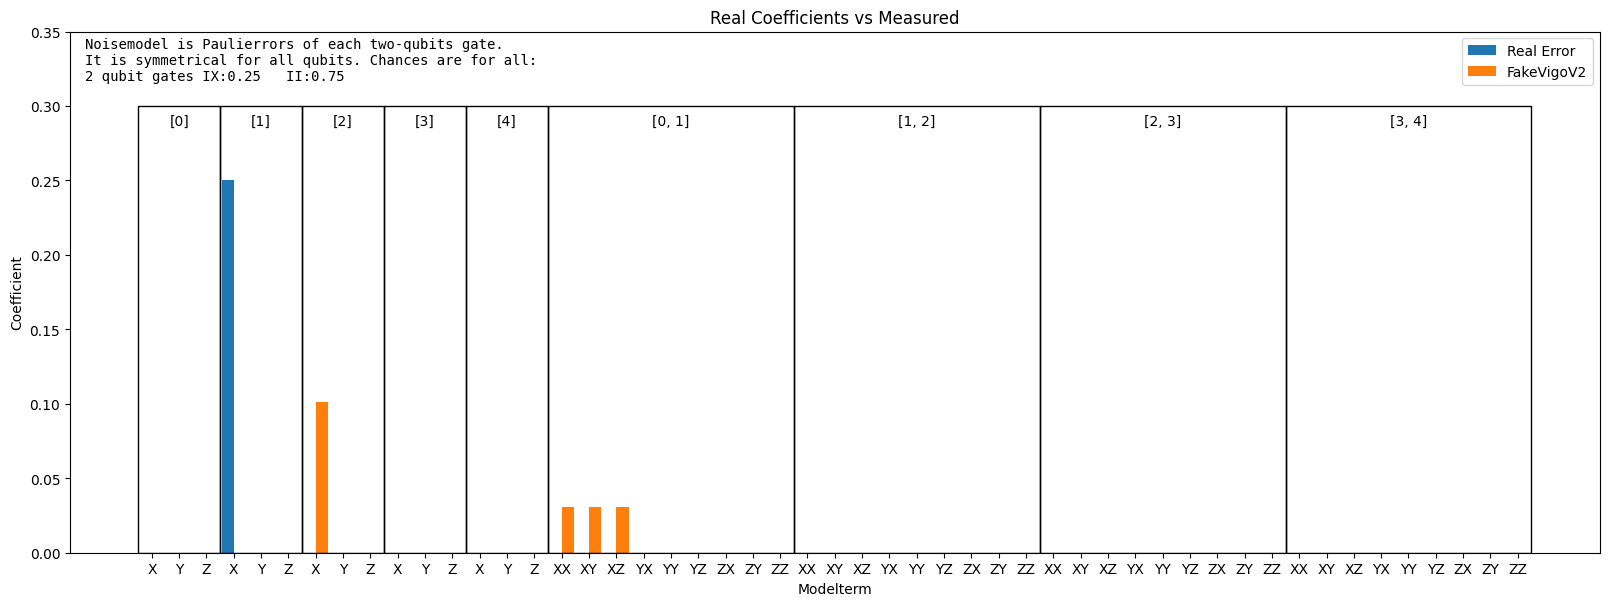

In [50]:
#print([len(item) for item in infidelities_list])
fig, ax = plt.subplots(figsize=(16, 6))
x = np.arange(len(groups))  # Label locations
width = 0.9 / (len(filtered_folders)+1-failed_folders)  # Width of the bars, adjusted for the number of datasets


# Create the bar plot

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('Modelterm')
ax.set_xticks(x)
ax.set_xticklabels([str(f).replace('I', '') for f in groups], rotation=0)

# Plotting bars for each folder's data dynamically
maxvalue = 0
for i in range(len(filtered_folders)+1-failed_folders):
    if coe:
        ax.bar(x + (i - (len(filtered_folders)-failed_folders)/2) * width, coeffs_list[i], width, label=labels[i])
        maxvalue = max([maxvalue, max(coeffs_list[i])])
    else:
        ax.bar(x + (i - (len(filtered_folders)-failed_folders)/2) * width, infidelities_list[i], width, label=labels[i])
        maxvalue = max([maxvalue, max(infidelities_list[i])])
print((len(filtered_folders)+1-failed_folders))
# Add legend
ax.legend()
if maxvalue != 0:
    ax.set_ylim(-maxvalue*0, maxvalue * 1.4)

textstr = 'Noisemodel is Paulierrors of each two-qubits gate.\nIt is symmetrical for all qubits. Chances are for all:\n2 qubit gates ' + twoqubit_error_string# + '\n1 qubit gates ' + singlequbit_error_string

# Customize the textbox position and appearance
props = dict(boxstyle='round', facecolor='lightblue', alpha=0)
#props = dict()

# Place the textbox in the top-left corner inside the plot (adjust x and y as needed)
ax.text(0.01, 0.99, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='left', bbox=props, family='monospace')

from matplotlib.patches import Rectangle

boxes = []
texts = []
i = 0
for j in range(5):
    array = [i, i+1, i+2]
    i+=3
    boxes.append(array)
    texts.append("[" + str(j) + "]")

for j in range(4):
    array = []
    for __ in range(9):
        array.append(i)
        i+=1
    boxes.append(array)
    texts.append("[" + str(j)+ ", " + str(j+1) + "]")
for group, text in zip(boxes, texts):
    rect_1 = Rectangle((min(group) - 0.5, -maxvalue*0), width=len(group), height=maxvalue*1.2, 
                    edgecolor='black', linewidth=1, facecolor='none')
    ax.add_patch(rect_1)
    ax.text(sum(group)/len(group), maxvalue*1.15, text, fontsize=10, ha='center')

#rect = Rectangle((-50, 0), width=10000, height=0, edgecolor='black', linewidth=1, facecolor='none')
#ax.add_patch(rect)

# Display the plot
plt.tight_layout()
#plt.show()
if coe:
    ax.set_title('Real Coefficients vs Measured')
    ax.set_ylabel('Coefficient')
    plt.savefig("Coefficient", bbox_inches='tight')
else:
    ax.set_title('Real Infidelity vs Measured')
    ax.set_ylabel('Infidelity')
    plt.savefig("Infidelity", bbox_inches='tight')

In [51]:
[i for i in coeffs_list[1] if i != 0]

[0.1011763728462079,
 0.0308684817341201,
 0.0308684817341201,
 0.030868481734120098]